# Graph densification using Wikipedia
In this tutorial, I will show you how to grow a graph from an initial sparse graph using node features. In this case, we will start from an extremely sparse graph, in fact a tree! The species tree made available from [STRING](https://string-db.org/). We will mine textual features from Wikipedia using the lovely [Wikipedia Python package](https://github.com/goldsmith/Wikipedia), embed them using a pre-trained [SciBERT model](https://github.com/allenai/scibert) and then use [GRAPE](https://github.com/AnacletoLAB/grape) to grow the initial graph.

Of course, this procedure can be executed on any set of node features you might have. Using wikipedia is only done in order to provide an intuitive and rather general set of features you may want to use, thought [please use wikipedia textual entries with a grain of salt!](https://en.wikipedia.org/wiki/Grain_of_salt)

Increasing the density of a graph can help improve graph ML models predictions by translating knowledge, such as textual information, into topology. For instance, there may be chocking points (for instance through a single node) in the graph topology that lead to information destruction when using models such as graph convolutional network, as all information will be combined with a weighted average. Having multiple nodes will allow for several weighted averages, allowing for less information destruction, as the model has the change to weight in several different manner semantically connected information.

## What is a graph density?
The density of a graph is defined as the number of edges divided by the number of possible edges, i.e. the number of nodes squared, N^2. The sparsest possible connected graph is a tree, where there is exactly N-1 edges.

## Retrieving the graph

In [1]:
from grape.datasets.string import SpeciesTree

2023-03-27 09:30:59.742798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


As per all the graphs in the [graph retrieval of the GRAPE library](https://github.com/AnacletoLAB/grape/blob/main/tutorials/Ensmallen_Automatic_graph_retrieval_utilities.ipynb), getting this graph is just a simple one-liner:

In [2]:
graph = SpeciesTree()

Let's see the [graph report](https://github.com/AnacletoLAB/grape/blob/main/tutorials/Create%20extensive%20knowledge%20graph%20reports%20using%20GRAPE.ipynb):

In [3]:
graph

<div class="graph-report"><style>.graph-report li {margin: 0.5em 0 0.5em 0;}.graph-report .paragraph {text-align: justify;word-break: break-all;}.graph-report .small-columns {column-count: 4;column-gap: 2em;}.graph-report .medium-columns {column-count: 3;column-gap: 2em;}.graph-report .large-columns {column-count: 2;column-gap: 2em;}.graph-report .single-column {}@media only screen and (max-width: 600px) {.graph-report .small-columns {column-count: 1;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 600px) and (max-width: 800px) {.graph-report .small-columns {column-count: 2;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 800px) and (max-width: 1024px) {.graph-report .small-columns {column-count: 3;}.graph-report .medium-columns {column-count: 2;}.graph-report .large-columns {column-count: 1;}}</style><h2>SpeciesTree</h2><p class="paragraph">The undirected graph SpeciesTree has 24.62K heterogeneous nodes and 24.61K heterogeneous edges. The graph is connected, that is, it is composed of a single connected component that includes all nodes and edges. The RAM requirements for the nodes and edges data structures are 3.63MB and 393.93KB respectively.</p><h3 style="margin: 1em 0 0 0;">Degree centrality</h3><p class="paragraph">The minimum node degree is 1, the maximum node degree is 163, the mode degree is 1, the mean degree is 2.00 and the node degree median is 1.</p><p class="paragraph">The nodes with the highest degree centrality are Lactobacillus (degree 163 and node type Bacteria), Streptomyces (degree 156 and node type Bacteria), Bacillus (degree 128 and node type Bacteria), unclassified Streptomyces (degree 123 and node type Bacteria) and Rhodobacteraceae (degree 105 and node type Bacteria).</p><h3 style="margin: 1em 0 0 0;">Node types</h3><p class="paragraph">The graph has 4 node types, which are Bacteria (19.13K nodes, 77.72%), Eukaryota (4.50K nodes, 18.27%), Archaea (987 nodes, 4.01%) and Ancestral. The RAM requirement for the node types data structure is 1.28MB.</p><h4 style="margin: 1em 0 0 0;">Singleton node types</h4><p class="paragraph">Singleton node types are node types that are assigned exclusively to a single node, making the node type relatively meaningless, as it adds no more information than the node name itself. The graph contains a singleton node type, which is Ancestral (node cellular organisms (degree 3 and node type Ancestral)).</p><h3 style="margin: 1em 0 0 0;">Edge types</h3><p class="paragraph">The graph has 3 edge types, which are Bacteria (38.26K edges, 77.72%), Eukaryota (8.99K edges, 18.27%) and Archaea (1.97K edges, 4.01%). The RAM requirement for the edge types data structure is 197.29KB.</p><h3 style="margin: 1em 0 0 0;">Topological Oddities</h3><p class="paragraph">A topological oddity is a set of nodes in the graph that <i>may be derived</i> by an error during the generation of the edge list of the graph and, depending on the task, could bias the results of topology-based models. In the following paragraph, we will describe the detected topological oddities.</p><h4 style="margin: 1em 0 0 0;">Trees</h4><p class="paragraph">A tree is a connected component with <code>n</code> nodes and <code>n-1</code> edges. We have detected  a single tree in the graph, involving a total of 24.62K nodes (100.00%) and 49.23K edges (100.00%).</p><ul class="large-columns"><li><p class="paragraph">Tree starting from the root node Craniata (degree 2 and node type Eukaryota), and containing 24.62K nodes, with a maximal depth of 33, which are Chordata (degree 4 and node type Eukaryota), Vertebrata (degree 3 and node type Eukaryota), Tunicata (node type Eukaryota), Cephalochordata (node type Eukaryota) and Deuterostomia (degree 4 and node type Eukaryota). Its nodes have 4 node types, which are Bacteria (19.13K nodes, 77.72%), Eukaryota (4.50K nodes, 18.26%)

The graph, being a tree, has an extremely low density:

In [4]:
graph.get_density()

8.124796880077999e-05

## Wikipedia python package
You can install, as usual, the wikipedia python package by running:

```
pip install wikipedia
```

We can try the fantastic APIs made available by the [wikipedia Python package](https://github.com/goldsmith/Wikipedia):

In [5]:
import wikipedia

wikipedia.summary("Azorhizobium")

'Azorhizobium is a genus of Gram-negative soil bacteria. They fix nitrogen in symbiosis with plants in the genus Sesbania. Strain ORS571 of A. caulinodans has been fully sequenced.Azorhizobium caulinodans ORS571 has exceptional properties because it is able to fix nitrogen in both aerobic free-living and symbiotic states Azorhizobium caulinodans ORS571 is a rice and wheat endophyte, and does not need plant metabolites to make functional nitrogenase, but low nitrogenase expression is observed when it is living in cereal roots.'

That description seems about right!

## Retrieving the node type descriptions
We want to retrieve all textual descriptions that may be useful from Wikidata. In order to do so, we will start with the node type descriptions.

In [6]:
%%time
from tqdm.auto import trange
import pandas as pd

node_types_description = pd.DataFrame([
    dict(
        node_type_name=graph.get_node_type_name_from_node_type_id(node_type_id),
        description=wikipedia.summary(graph.get_node_type_name_from_node_type_id(node_type_id))
    )
    for node_type_id in trange(graph.get_number_of_node_types())
])

node_types_description

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 282 ms, sys: 27.5 ms, total: 310 ms
Wall time: 3.13 s


node_type_name                                        description
0       Bacteria  Bacteria ( (listen); singular: bacterium) are ...
1        Archaea  Archery is the sport, practice, or skill of us...
2      Eukaryota  Eukaryota, whose members are known as eukaryot...
3      Ancestral  An ancestor, also known as a forefather, fore-...

## Retrieving the node descriptions
We want now to retrieve textual descriptions for all the possible nodes from Wikidata. Since not all nodes will be available from Wikipedia, we need to handle a bit more of corner cases. In order to do this cleanly, let's set up a simple python function:

In [7]:
from typing import List

def get_description(node_name: str) -> str:
    """Returns the wikipedia description for the provided node name.
    
    Parameters
    ---------------
    node_name: str,
        The node name to retrieve the wikipedia entri for.
        
    Returns
    ---------------
    The textual description if found, or an empty string if not.
    """
    try:
        search_results: List[str] = wikipedia.search(
            node_name
        )
        for search_result in search_results:
            try:
                return wikipedia.summary(
                    search_result
                )
            except Exception as e:
                pass
    except Exception as e:
        print(e, node_name)
    return ""

We can start the mining process. This step will take a while.

Do note that our goal is not to get great features for all nodes: while that would be preferable, here our target is more modest. We want decent features for a majority of the nodes.

In [10]:
%%time
node_descriptions = pd.DataFrame([
    dict(
        node_name=graph.get_node_name_from_node_id(node_id),
        description=get_description(
            graph.get_node_name_from_node_id(node_id),
        ),
    )
    for node_id in trange(graph.get_number_of_nodes())
])

node_descriptions

  0%|          | 0/24616 [00:00<?, ?it/s]

CPU times: user 5min 19s, sys: 30.7 s, total: 5min 50s
Wall time: 1h 8min 49s


node_name  \
0                      Bacteria   
1                  Azorhizobium   
2      Azorhizobium caulinodans   
3           Buchnera aphidicola   
4                    Cellvibrio   
...                         ...   
24611             Isosphaerales   
24612             Pirellulaceae   
24613                   Gleimia   
24614                    Winkia   
24615         core chlorophytes   

                                             description  
0      Bacteria ( (listen); singular: bacterium) are ...  
1      Azorhizobium is a genus of Gram-negative soil ...  
2      Azorhizobium caulinodans is a species of bacte...  
3      Buchnera aphidicola, a member of the Pseudomon...  
4      Cellvibrio is a genus of Gammaproteobacteria. ...  
...                                                  ...  
24611            Isosphaeraceae is a family of bacteria.  
24612        The Pirellulaceae are a family of bacteria.  
24613  Gleimia europaea is a bacterium from the genus...  
24614  Winkia neuii is a species of Gram-positive, ro...  
24615  Chlorophyll (also chlorophyl) is any of severa...  

[24616 rows x 2 columns]

Of course, this is a procedure that is feaseable on rather small graphs. For larger graphs, you will need to [download wikipedia](https://en.wikipedia.org/wiki/Wikipedia:Database_download) and create a [reverse index](https://en.wikipedia.org/wiki/Reverse_index) so to query rapidly Wikipedia and scale to graphs with millions of nodes.

Let's count how many nodes now have textual features:

In [11]:
(node_descriptions.description.str.len() > 0).mean()

0.653436789080273

So about `65%` of the nodes now has a description!

We remove the newline characters:

In [13]:
node_descriptions["description"] = node_descriptions.description.str.replace("\n", " ")

We store the node features into a CSV, called `node_descriptions.csv`

In [14]:
node_descriptions.to_csv("node_descriptions.csv", index=False)

## Embedding the textual node features
To embed the textual node features we use the [BM25-weighted BERT approach described here](https://github.com/AnacletoLAB/grape/blob/main/tutorials/BM25_weighted_pretrained_BERT_based_textual_embedding_using_GRAPE.ipynb). Specifically, since these features are regarding scientific topics, we will use [SciBERT](https://github.com/allenai/scibert). If your features have nothing to do with science, do use a better suited BERT models. There are many on the [HuggingFace website](https://huggingface.co/).

In [16]:
%%time
from grape.datasets import get_okapi_tfidf_weighted_textual_embedding

embedding = pd.DataFrame(
    get_okapi_tfidf_weighted_textual_embedding(
        path="./node_descriptions.csv",
        pretrained_model_name_or_path="allenai/scibert_scivocab_uncased"
    ),
    index=graph.get_node_names()
)

embedding

CPU times: user 3.02 s, sys: 635 ms, total: 3.65 s
Wall time: 5.43 s


0         1         2         3         4    \
Bacteria                  0.079163 -0.027420  0.053986  0.042297  0.003330   
Azorhizobium              0.019669 -0.020752  0.004013 -0.017639  0.014923   
Azorhizobium caulinodans  0.067017 -0.072205  0.016998 -0.061646  0.052673   
Buchnera aphidicola      -0.095703  0.016113 -0.018036 -0.089355 -0.050934   
Cellvibrio               -0.014885 -0.007462 -0.006157  0.002167  0.000616   
...                            ...       ...       ...       ...       ...   
Isosphaerales             0.002499 -0.016388  0.005280 -0.005680  0.002609   
Pirellulaceae             0.001274 -0.020264  0.001791 -0.001414 -0.002237   
Gleimia                   0.012047 -0.015442 -0.016693 -0.017410 -0.044250   
Winkia                   -0.026947  0.010269 -0.005127 -0.006325 -0.030548   
core chlorophytes         0.461426 -0.086060 -0.058685 -0.191528  0.067749   

                               5         6         7         8         9    \
Bacteria                 -0.033203  0.048798  0.039368  0.058746 -0.053558   
Azorhizobium             -0.005539 -0.010696  0.003384  0.016876 -0.025894   
Azorhizobium caulinodans -0.024139 -0.036438  0.014259  0.060272 -0.094482   
Buchnera aphidicola      -0.162598  0.120667 -0.059082  0.065186 -0.078918   
Cellvibrio               -0.016647 -0.005306 -0.005791  0.009140  0.007305   
...                            ...       ...       ...       ...       ...   
Isosphaerales            -0.010086 -0.007401 -0.000592 -0.010971  0.006405   
Pirellulaceae            -0.025940 -0.018326  0.000348 -0.002850  0.007618   
Gleimia                  -0.002747 -0.015915 -0.052673  0.038696  0.031799   
Winkia                    0.006416 -0.028824 -0.004204  0.030334  0.025253   
core chlorophytes         0.161377 -0.123230 -0.638672 -0.120605 -0.176636   

                          ...       758       759       760       761  \
Bacteria                  ...  0.020126 -0.006260  0.029404 -0.014526   
Azorhizobium              ... -0.012207  0.008278 -0.019455 -0.001808   
Azorhizobium caulinodans  ... -0.041962  0.028625 -0.076843 -0.004013   
Buchnera aphidicola       ... -0.015182 -0.067688 -0.017059 -0.087952   
Cellvibrio                ...  0.011429 -0.034058  0.026459 -0.019257   
...                       ...       ...       ...       ...       ...   
Isosphaerales             ...  0.001920 -0.006145  0.000890  0.002193   
Pirellulaceae             ... -0.008751 -0.001057  0.004120 -0.006001   
Gleimia                   ... -0.034821 -0.040436  0.003708 -0.079529   
Winkia                    ...  0.008728 -0.002607  0.010681 -0.003510   
core chlorophytes         ... -0.119934 -0.396973  0.475342 -0.268066   

                               762       763       764       765       766  \
Bacteria                  0.081543  0.077332 -0.072937  0.059235  0.055542   
Azorhizobium             -0.000603 -0.004841  0.001305  0.005180 -0.001804   
Azorhizobium caulinodans -0.007702 -0.019547  0.005981  0.013901 -0.007271   
Buchnera aphidicola      -0.015778 -0.079529  0.021393 -0.022385 -0.024994   
Cellvibrio                0.007912 -0.014679  0.014275  0.003063  0.016006   
...                            ...       ...       ...       ...       ...   
Isosphaerales             0.007660 -0.002789 -0.001071 -0.002613 -0.011848   
Pirellulaceae             0.007736 -0.002222 -0.004639  0.001538 -0.019104   
Gleimia                  -0.014328 -0.048767 -0.005260  0.025452 -0.065491   
Winkia                   -0.000509 -0.024933 -0.014687 -0.011513  0.024139   
core chlorophytes         0.352539  0.063904  0.753418  0.625488  0.132568   

                               767  
Bacteria                 -0.136108  
Azorhizobium             -0.023087  
Azorhizobium caulinodans -0.078369  
Buchnera aphidicola      -0.089233  
Cellvibrio               -0.008652  
...                            ...  
Isosphaerales            -0.009003  
Pirellulaceae             0.003138  
Gleimia   

We can visualize the features with a TSNE:

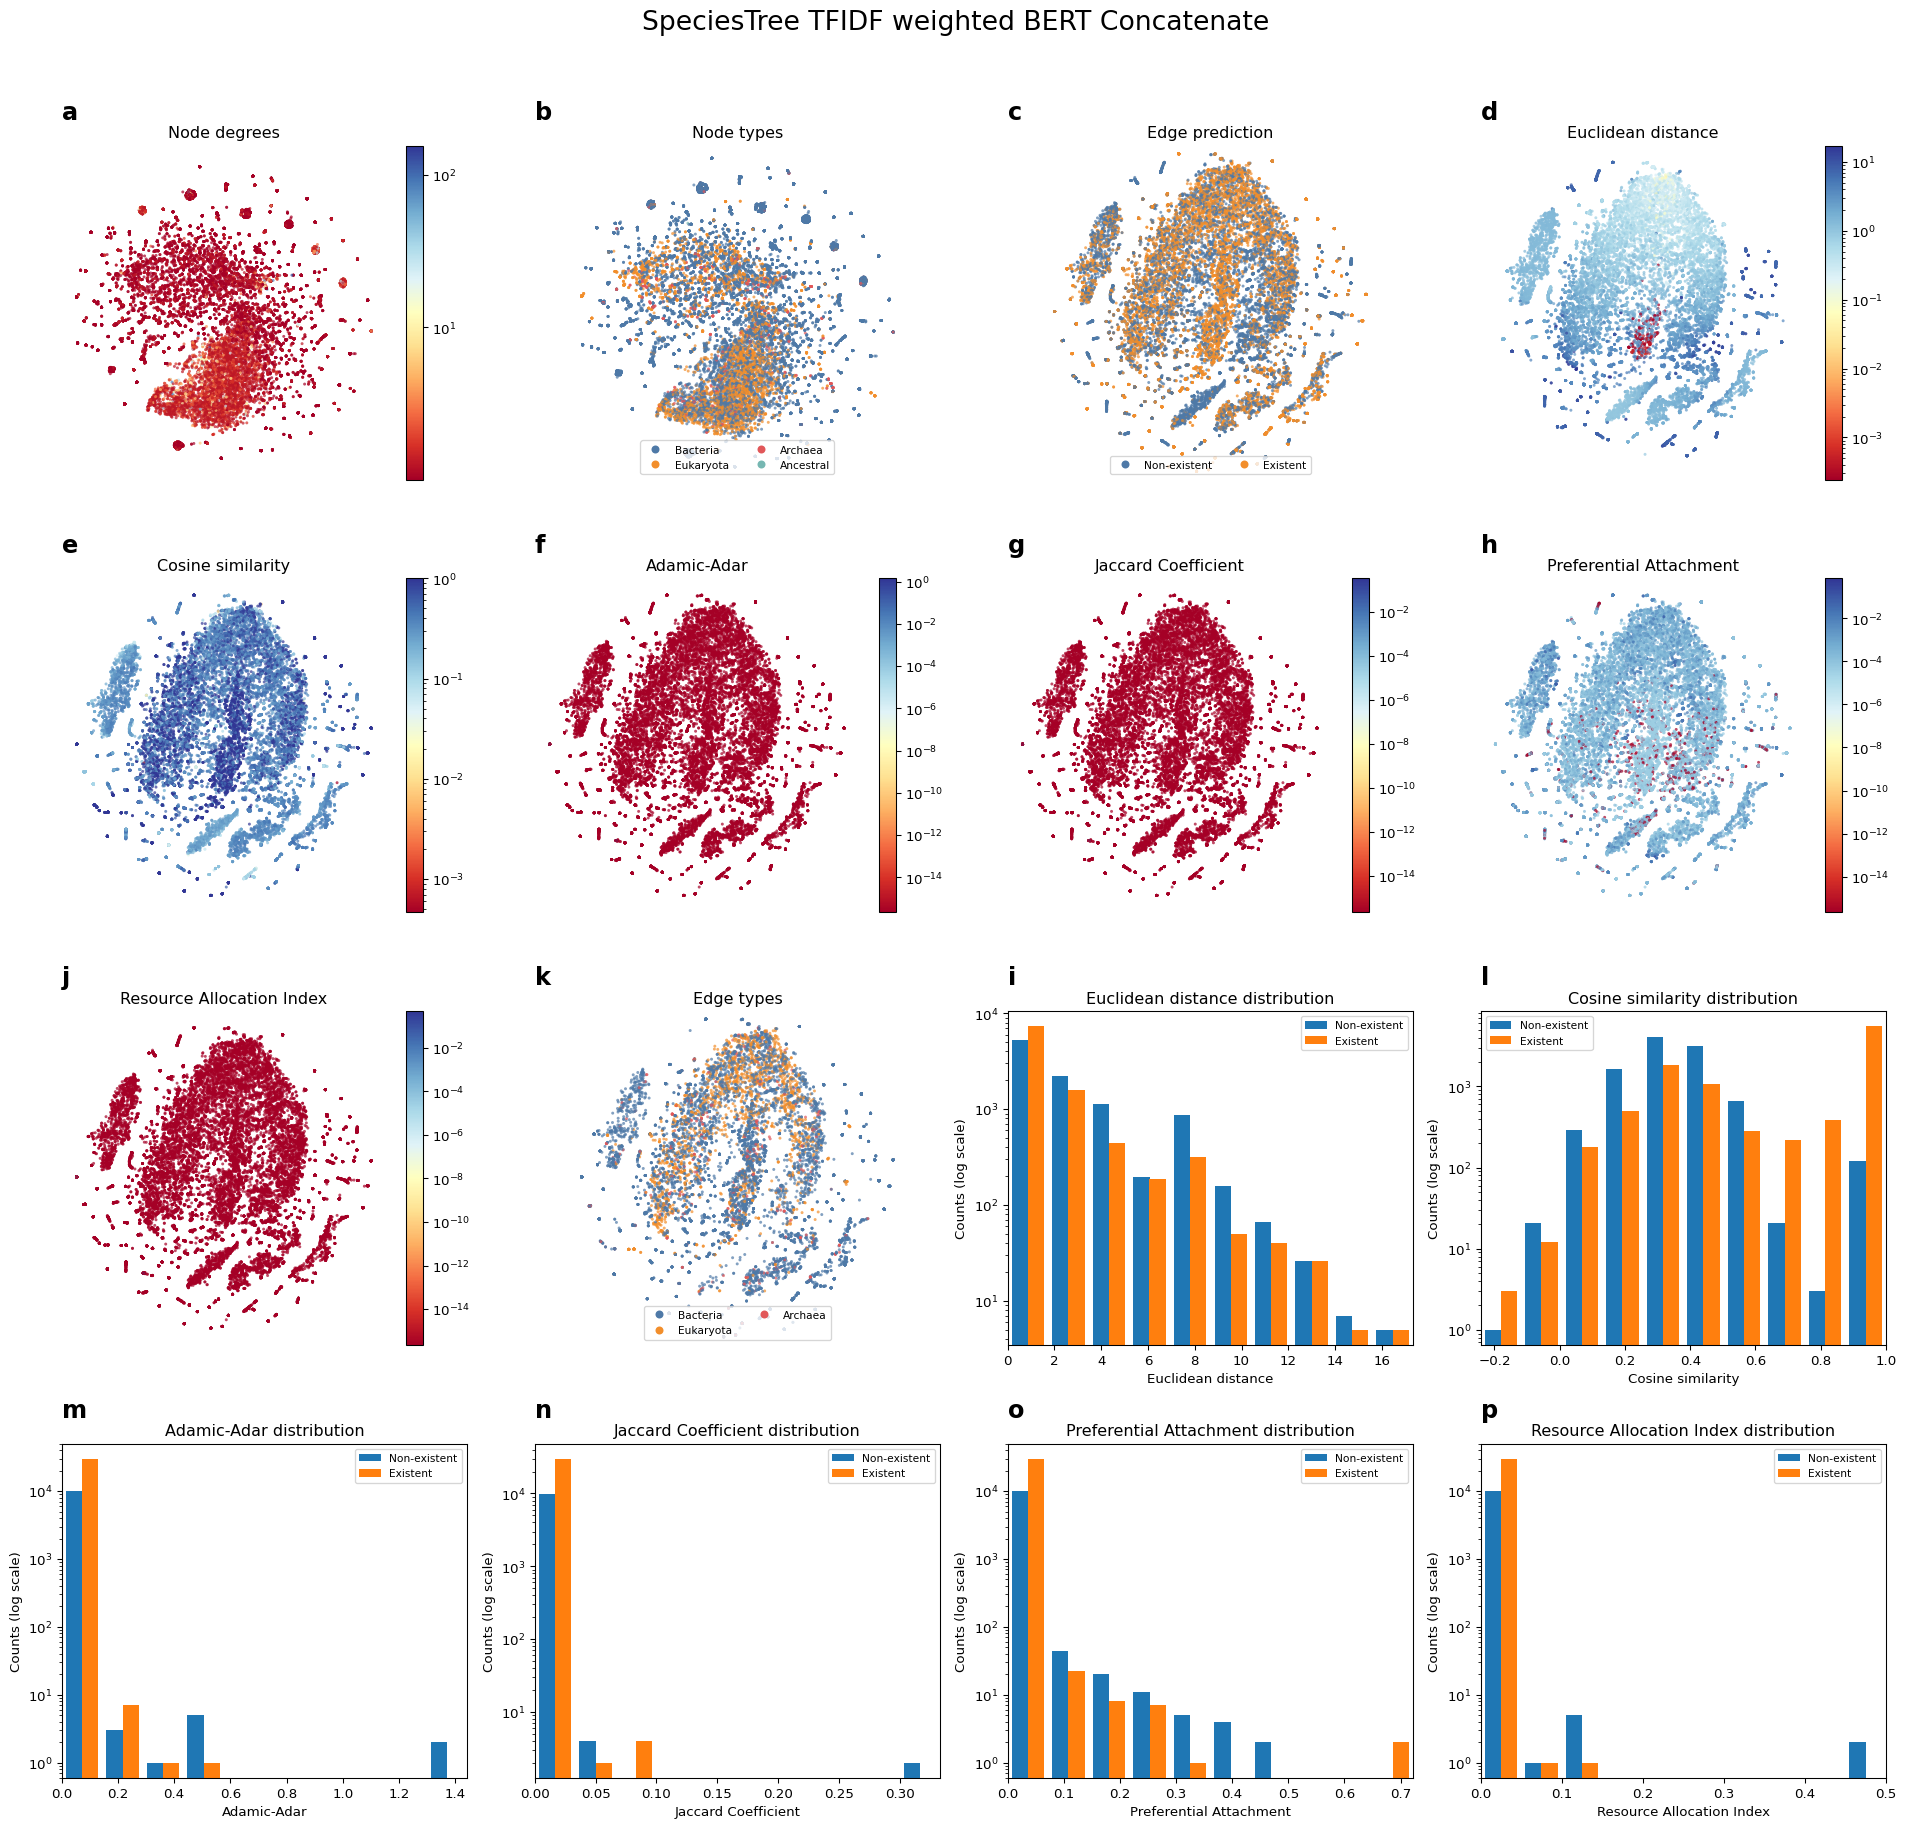

In [17]:
from grape import GraphVisualizer

GraphVisualizer(graph).fit_and_plot_all(embedding)

The features do not seem to match with the graph topology, but the cosine similarity is pretty high! These node descriptions may be useful after all!

## Growing your graph
Finally, now that we have node features, we can grow our very sparse graph!

Let's take a look at the node degree distribution of the original graph, which, again, is a simple tree.

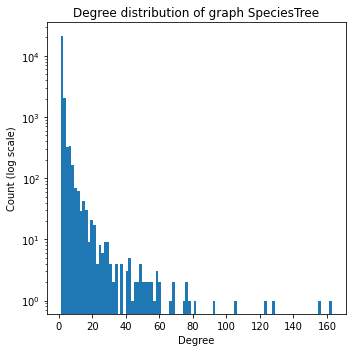

In [18]:
from grape import GraphVisualizer

GraphVisualizer(graph).plot_node_degree_distribution()

We have most nodes within the `10` degree margin, and we want to increase their connectivity. Do note that this is not yet the most efficient implementation, and much of this can be sped up.

**This procedure is currently QUADRATIC and meant to be used only on the very low density areas of a normal graph. A tree is a pathological case where almost all of the graph is low density.**

In [19]:
%%time
new_graph = graph.generate_new_edges_from_node_features(
    # We pass the textual embeddding we have just computed
    features=embedding.values,
    # We will only work on nodes with degree less than 10
    max_degree=10,
    # We want to add 5 new neighbours to all nodes with degree less than 10.
    neighbours_number=5,
    # We will use the COSINE distance, and add the 5 nodes that are closest to
    # the node we are currently working on.
    distance_name="COSINE",
    verbose=True
)

CPU times: user 32min 52s, sys: 1min 30s, total: 34min 22s
Wall time: 3min 9s


We can now plot the updated node degree distribution to see how it changed:

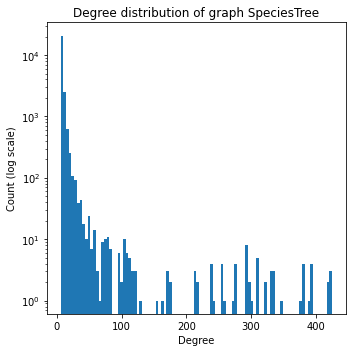

In [20]:
from grape import GraphVisualizer

GraphVisualizer(new_graph).plot_node_degree_distribution()

In the original graph we had:

In [21]:
graph.get_node_degrees_mean(), graph.get_node_degrees_median()

(1.9999187520311992, 1)

In the new graph we have:

In [22]:
new_graph.get_node_degrees_mean(), new_graph.get_node_degrees_median()

(9.480987975300618, 7)

Let's check out the new density of the graph:

In [23]:
new_graph.get_density()

0.0002604721089569754

This is much much denser! Let's now take a look at the graph report!

In [24]:
new_graph

<div class="graph-report"><style>.graph-report li {margin: 0.5em 0 0.5em 0;}.graph-report .paragraph {text-align: justify;word-break: break-all;}.graph-report .small-columns {column-count: 4;column-gap: 2em;}.graph-report .medium-columns {column-count: 3;column-gap: 2em;}.graph-report .large-columns {column-count: 2;column-gap: 2em;}.graph-report .single-column {}@media only screen and (max-width: 600px) {.graph-report .small-columns {column-count: 1;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 600px) and (max-width: 800px) {.graph-report .small-columns {column-count: 2;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 800px) and (max-width: 1024px) {.graph-report .small-columns {column-count: 3;}.graph-report .medium-columns {column-count: 2;}.graph-report .large-columns {column-count: 1;}}</style><h2>SpeciesTree</h2><p class="paragraph">The undirected multigraph SpeciesTree has 24.62K heterogeneous nodes and 116.69K heterogeneous edges. The graph is connected, that is, it is composed of a single connected component that includes all nodes and edges. The RAM requirements for the nodes and edges data structures are 3.63MB and 1.13MB respectively.</p><h3 style="margin: 1em 0 0 0;">Degree centrality</h3><p class="paragraph">The minimum node degree is 6, the maximum node degree is 425, the mode degree is 6, the mean degree is 9.48 and the node degree median is 7.</p><p class="paragraph">The nodes with the highest degree centrality are Candidatus Kinetoplastibacterium (degree 425 and node type Bacteria), Candidatus Arthromitus sp. SFB-mouse (degree 421 and node type Bacteria), Candidatus Kinetoplastibacterium crithidii (degree 421 and node type Bacteria), Candidatus Phytoplasma mali (degree 420 and node type Bacteria) and Candidatus Sodalis pierantonius str. SOPE (degree 420 and node type Bacteria).</p><h3 style="margin: 1em 0 0 0;">Node types</h3><p class="paragraph">The graph has 4 node types, which are Bacteria (19.13K nodes, 77.72%), Eukaryota (4.50K nodes, 18.27%), Archaea (987 nodes, 4.01%) and Ancestral. The RAM requirement for the node types data structure is 1.28MB.</p><h4 style="margin: 1em 0 0 0;">Singleton node types</h4><p class="paragraph">Singleton node types are node types that are assigned exclusively to a single node, making the node type relatively meaningless, as it adds no more information than the node name itself. The graph contains a singleton node type, which is Ancestral (node cellular organisms (degree 8 and node type Ancestral)).</p><h3 style="margin: 1em 0 0 0;">Edge types</h3><p class="paragraph">The graph has 3 edge types, which are Bacteria (38.26K edges, 77.72%), Eukaryota (8.99K edges, 18.27%) and Archaea (1.97K edges, 4.01%). The RAM requirement for the edge types data structure is 933.91KB.</p><h4 style="margin: 1em 0 0 0;">Unknown edge types</h4><p class="paragraph">Edges with unknown edge types are edges with a edge type that was not provided during the creation of the graph, which may be desired as the output of a edge-label holdout. The graph contains 184154 edges with unknown edge type, which are edge between "Bacteria (degree 23 and node type Bacteria)" and "[Cellvibrio] gilvus ATCC 13127 (degree 6 and node type Bacteria)" with unknown edge type, edge between "Azorhizobium (degree 14 and node type Bacteria)" and "Cellvibrio (degree 13 and node type Bacteria)" with unknown edge type, edge between "Azorhizobium (degree 14 and node type Bacteria)" and "Sinorhizobium fredii NGR234 (degree 12 and node type Bacteria)" with unknown edge type, edge between "Azorhizobium (degree 14 and node type Bacteria)" and "Buchnera aphidicola (Tuberolachnus salignus) (degree 7 and node type Bacteria)" with unknown edge type, edge between "Azorhizobium (degree 14 and node type Bacteria)" and "Buchnera aphidicola (Baizongia pistaciae) (degree 8 a

Let's compare how a simple topological embedding method such as [First-order LINE](https://github.com/AnacletoLAB/grape/blob/main/tutorials/Using_First-order_LINE_to_embed_Cora.ipynb).

First, let's visualize using [TSNE](https://github.com/AnacletoLAB/grape/blob/main/tutorials/Multiple%20Species%20Tree%20visualizations.ipynb) the first-order LINE embedding of the original sparse graph:

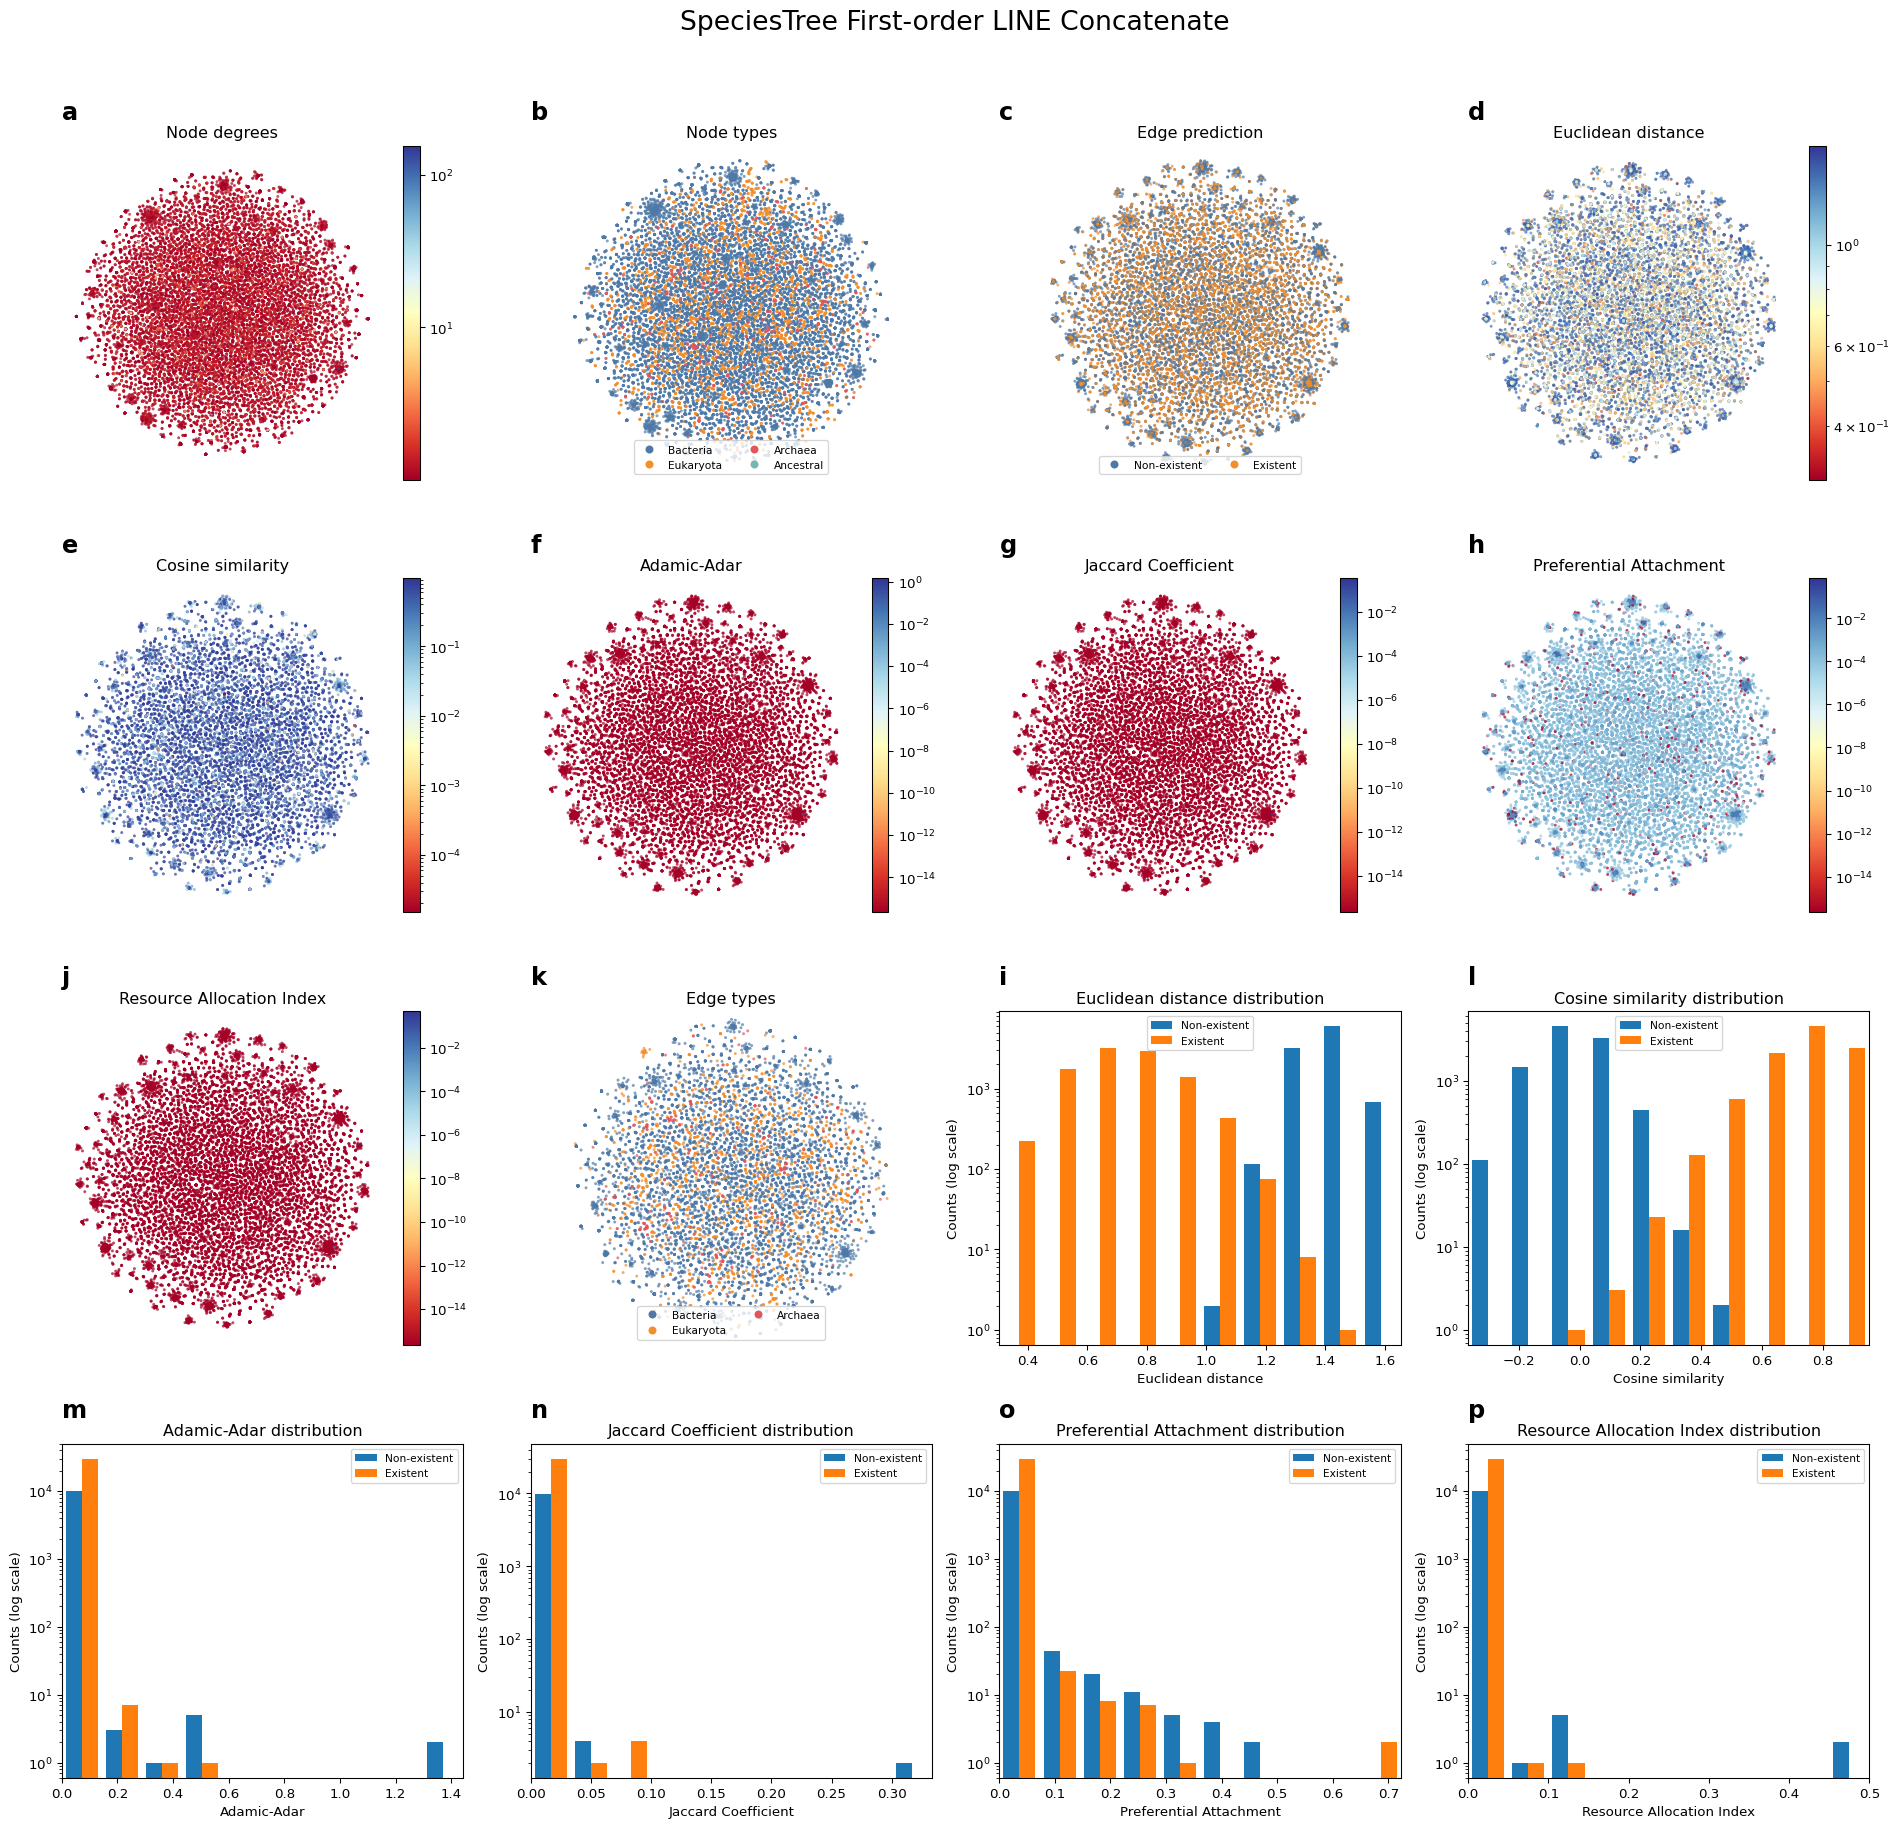

In [25]:
from grape import GraphVisualizer

GraphVisualizer(graph).fit_and_plot_all("First-order LINE")

While the LINE embedding seems to be very accurately matching the graph topology **BEWARE!** This is evaluated on the training graph, and that is just overfitting. Note how all edge prediction metrics are useless, for instance the jaccard index does not predict any better than random chance, and there is no predictions for the node types-

And the densified version:

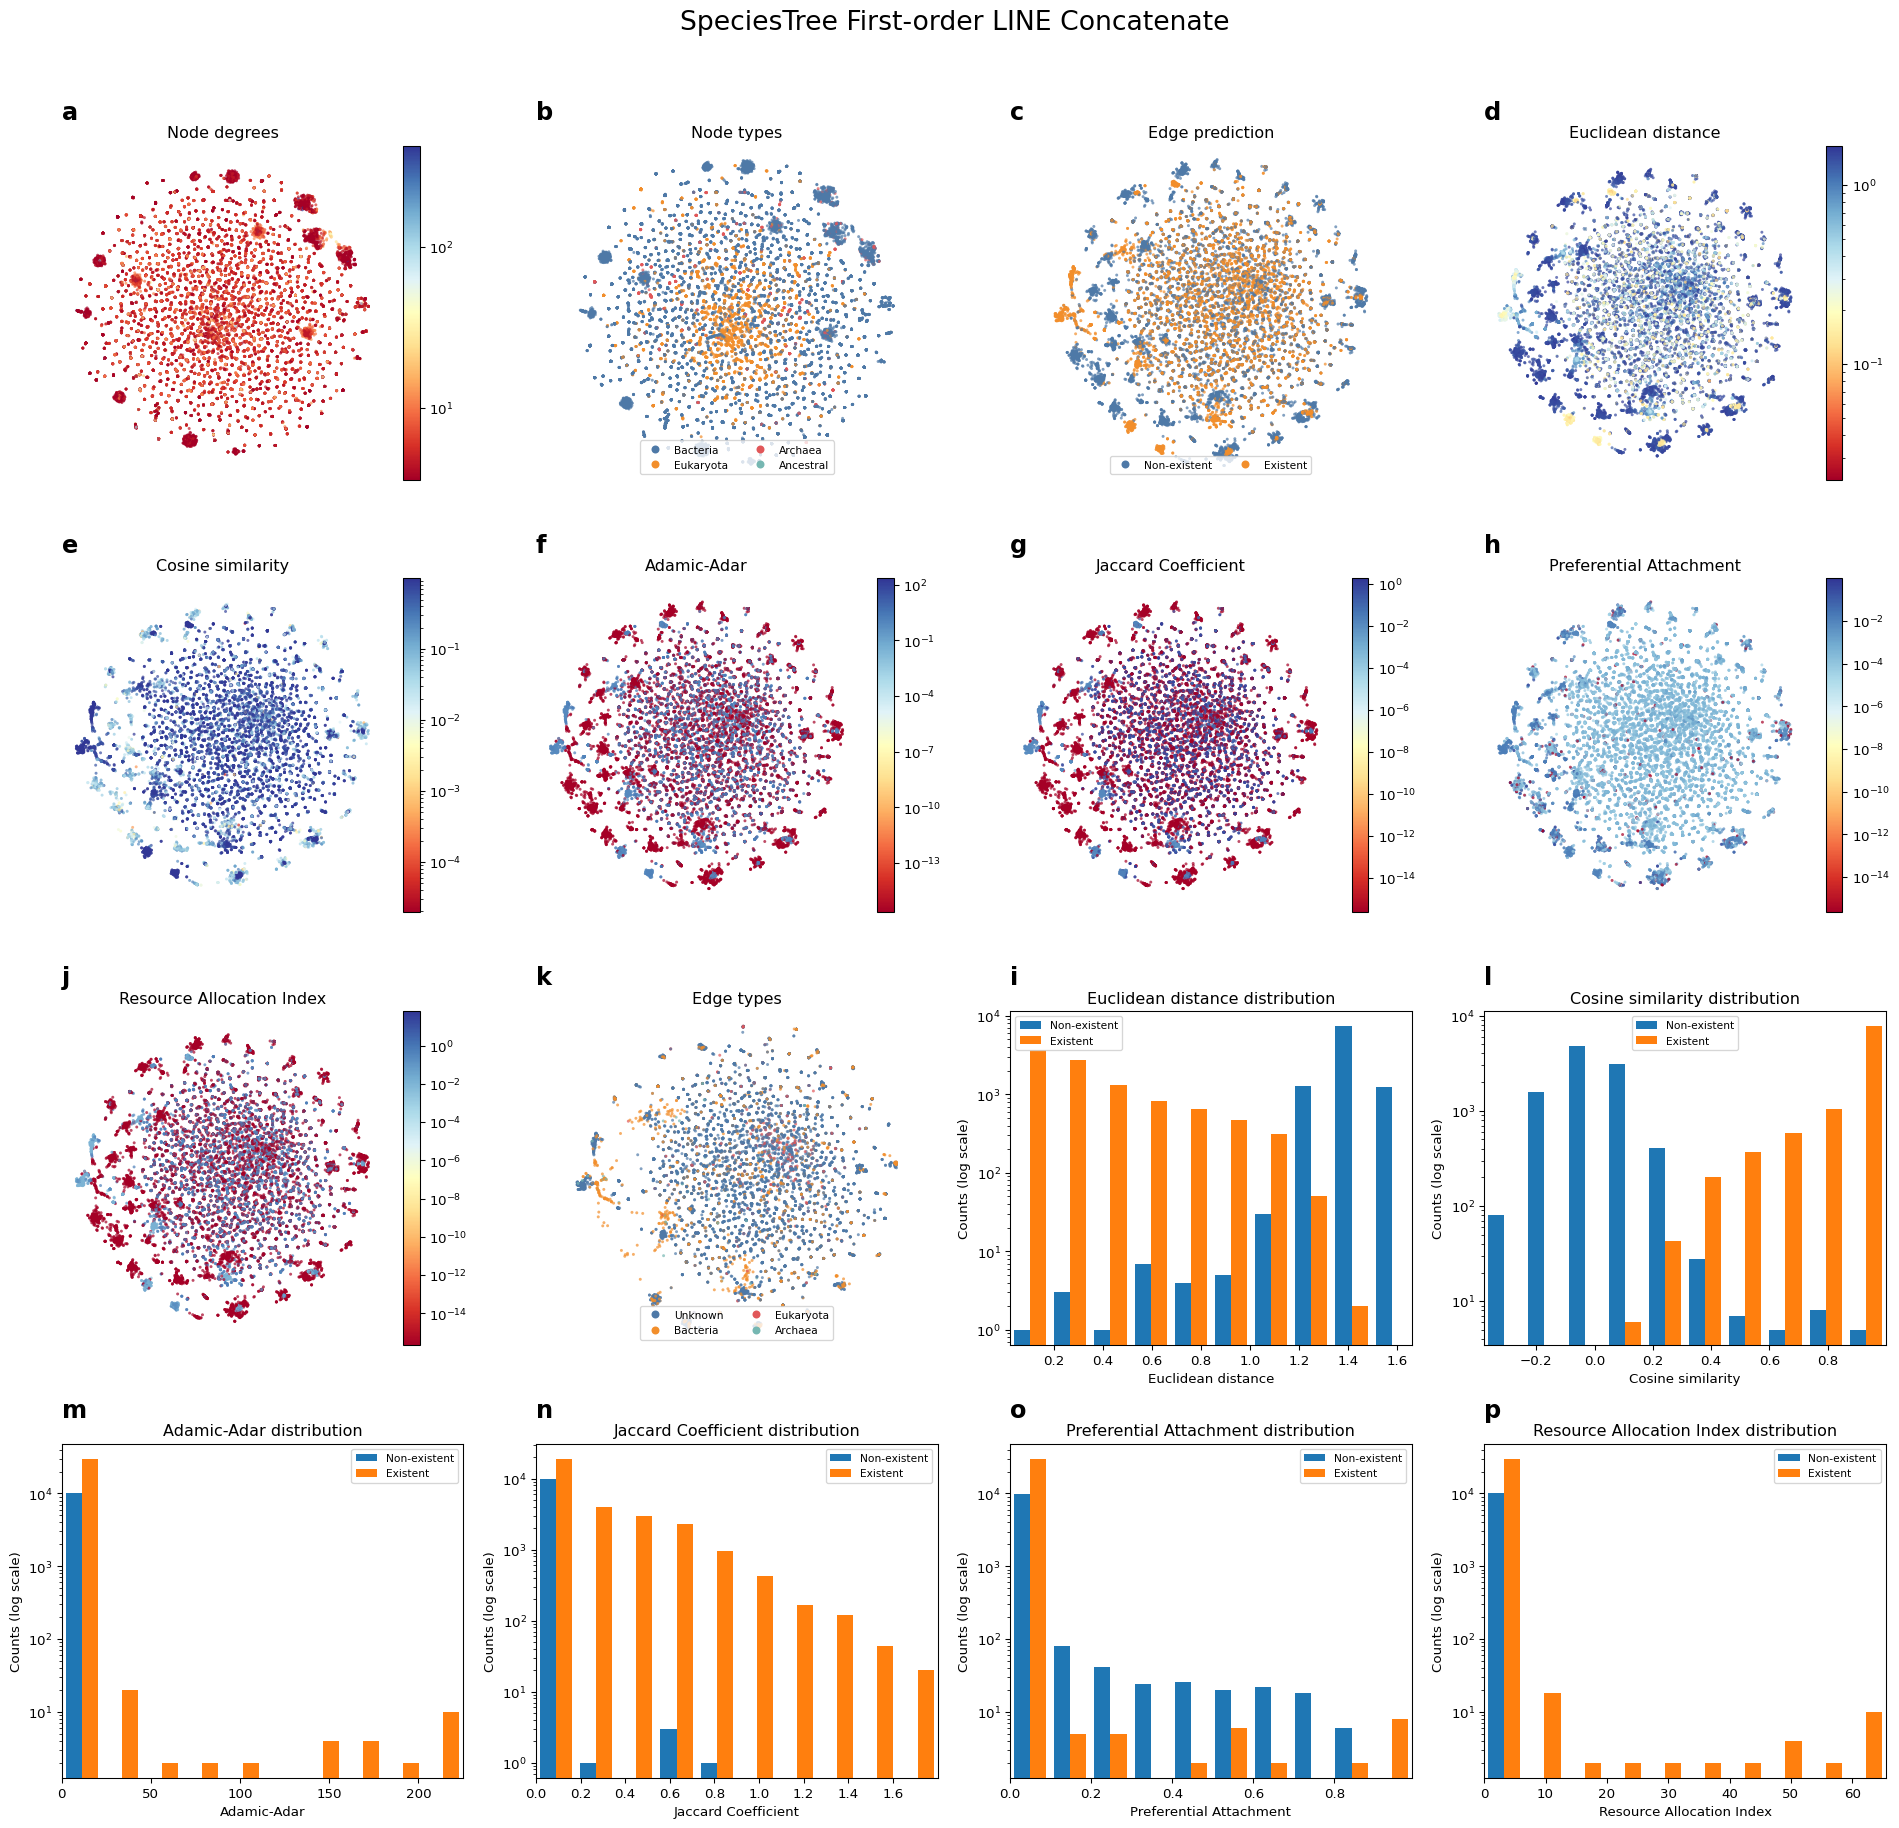

In [26]:
from grape import GraphVisualizer

GraphVisualizer(new_graph).fit_and_plot_all("First-order LINE")

Now we are talking! By including this additional knowledge, we now have signal from several topological metrics! Still, these performance mean very little when evaluated directly on the training graph.

To properly evaluate them, [we need to use graph holdouts, which I describe in this previous tutorial](https://github.com/AnacletoLAB/grape/blob/main/tutorials/Graph_holdouts_using_GRAPE.ipynb).

## Conclusion
This tutorial showcased the process of graph densification using Wikipedia, SciBERT, and GRAPE. By growing a graph from an initial sparse tree graph, the tutorial demonstrated how to mine textual features from Wikipedia and embed them using a pre-trained SciBERT model. This process can be executed on any set of node features to improve the density of a graph and, thus, improve the predictions of graph ML models. This tutorial can be scaled to larger graphs by downloading Wikipedia and creating a reverse index for faster querying.

There are surely several different heuristics one may want to use while growing their graph, but even this extremely simple one is useful to increase connectivity even in desperate situations.

Do consider [following me on LinkedIn](https://www.linkedin.com/in/lucacappelletti94/) for more tutorials, and do [star the GRAPE repository](https://github.com/AnacletoLAB/grape)!